In [3]:
%reset -f

In [4]:
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# import plottools
# import torch                      #PyTorch
# import torch.nn as nn             #PyTorch module for neural nets
# from torch.autograd import grad   #For taking derivatives

from IPython.display import clear_output
# import sys

from scipy.optimize import fsolve
# from scipy.sparse import spdiags

import scipy.sparse as sp
# Plot Tools

# import itertools as iter
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator

import warnings
warnings.simplefilter('ignore')

import ray

import pyvista as pv
from pyvista.utilities import lines_from_points
# from itkwidgets import view

object that solve the equilibrium price given endowment w

In [5]:
class Manifold:

    def __init__(self, w_a1, w_a2, w_1, w_2, k):

        self.w_1 = w_1
        self.w_2 = w_2

        self.w_a1 = w_a1
        self.w_a2 = w_a2
        self.w_b1 = w_1 - w_a1
        self.w_b2 = w_2 - w_a2
        self.k = k
    
    def excess(self, plot):

        # p sequence to obtain the initial guess
        p_bar = np.linspace(1E-10, 20, 50000)
        if plot == True:
             p_bar = np.linspace(1E-2, 100, 50000)

        len = p_bar.__len__()
        
        # two excess demand function
        z_1 = self.w_a1 + (1/p_bar)*self.w_a2 - (1/p_bar)**(self.k/(self.k+1)) + p_bar**(-1/(self.k+1)) - self.w_1 
        z_2 = (1/p_bar)**(-1/(self.k+1)) + p_bar*self.w_b1 + self.w_b2 - p_bar**(self.k/(self.k+1)) - self.w_2

        z = z_1
        opp = z[0:len-1] * z[1:len]

        if plot == True:
            plt.plot(p_bar, z, color ='k', alpha = 0.1)
        
        self.i0 = p_bar[0:len-1][(opp < 0)]
        self.i0_len = self.i0.__len__()
        # return p_bar[0:len-1][(opp < 0)]
    
    def SolveP(self, i0):
        
        def z_fun(x):
            fn = self.w_a1 + (1/x)*self.w_a2 - (1/x)**(self.k/(self.k+1)) + x**(-1/(self.k+1)) - self.w_1 # z_1
            # fn = (1/x)**(-1/(self.k+1)) + x*self.w_b1 + self.w_b2 - x**(self.k/(self.k+1)) - self.w_2 # z_2
            return fn
    
        p_solved = fsolve(z_fun, i0)

        fcheck = 0
        if np.isclose(z_fun(p_solved), 0) == False:
            fcheck = 1

        return [self.w_a1, self.w_a2, p_solved[0], fcheck]

Object to obtain the Manifold

In [6]:
class GetResult:

    def __init__(self, k, surf = True):
        self.k = k
        self.w_1 = 2
        self.w_2 = 2
        begin = 0.1
        if surf == False:
            begin = 1E-7
        # self.Grid_1 = np.linspace(begin, self.w_1-begin, 200)
        # self.Grid_2 = np.linspace(begin, self.w_2-begin, 200)
        self.Grid_1 = np.concatenate((np.linspace(begin, 1, 50), np.linspace(1, self.w_1-begin, 100))) # for x_{a1}
        self.Grid_2 = np.concatenate((np.linspace(begin, 1, 100), np.linspace(1, self.w_2-begin, 50))) # for x_{a2}

    def ManifoldResult(self):

        Result = []
        for gg1 in self.Grid_1:
            for gg2 in self.Grid_2:

                MF = Manifold(gg1, gg2, self.w_1, self.w_2, self.k)
                MF.excess(False)

                for ii in range(MF.i0_len):
                    subResult = MF.SolveP(MF.i0[ii])
                    subResult.append(ii)
                    Result.append(subResult)
        
        Result = np.asarray(Result)
        Result = Result[(Result[:,3] == 0)]

        self.Result = Result

    # solve the contract curve
    def GetContract(self):

        w_a1, w_a2, p_bar = self.Result[:,[0]], self.Result[:,[1]], self.Result[:,[2]]
        
        x_a1 = w_a1 + (1/p_bar) * w_a2 - (1/p_bar)**(self.k/(self.k+1))
        x_a2 = (1/p_bar)**(-1/(self.k+1))
        
        Contract = np.hstack([w_a1, w_a2, x_a1, x_a2])
        Contract = Contract[np.where(Contract[:,2] * Contract[:,3] > 0)]
        Contract = Contract[np.where(Contract[:,2] < w_a1.max())]
        Contract = Contract[np.where(Contract[:,3] < w_a2.max())]
        
        E_contract = np.sort(Contract, 0)
        self.E_contract = E_contract
    
    # solve the no-trade equilibria
    def NonTrade(self):

        Result = []

        for ii in range(self.E_contract.__len__()):

            w_a1 = self.E_contract[ii,2]
            w_a2 = self.E_contract[ii,3]

            MF = Manifold(w_a1, w_a2, self.w_1, self.w_2, self.k)
            MF.excess(False)

            for jj in range(MF.i0_len):
                subResult = MF.SolveP(MF.i0[jj])
                subResult.append(0)
                Result.append(subResult)
        
        Result = np.asarray(Result)
        Result = Result[(Result[:,3] == 0)]
        self.NonTradeSet = Result

    # these are the grids with multiple solutions
    def MF_grid(self):
        self.MF_grid = self.Result[(self.Result[:,4] > 0)]
        

Activate the object

In [7]:
Man_baseline = GetResult(k=9)
Man_baseline.ManifoldResult()
Man_baseline.GetContract()
Man_baseline.NonTrade()
Man_baseline.MF_grid()

Reconstruct Surface

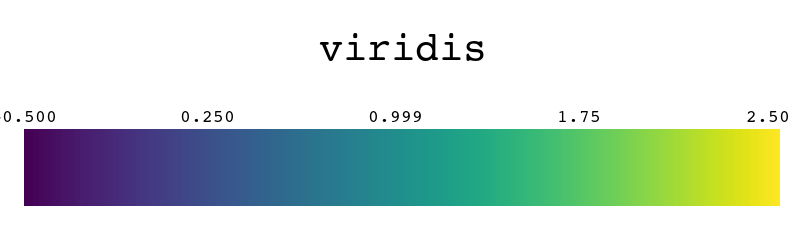

In [8]:
p_inf = 1/2

point = Man_baseline.Result[:,0:3]
point = point[point[:,2] < 5]

point[:,2] = point[:,2]*p_inf

cloud = pv.PolyData(point)

surf = cloud.reconstruct_surface()
surf = surf.extract_surface()
surf['Data'] = surf.points[:,[2]]
surf.save('MWG_example.stl')

point_notrade = Man_baseline.NonTradeSet[:,0:3]
point_notrade = point_notrade[point_notrade[:,2] < 5]
point_notrade[:,2] = point_notrade[:,2]*p_inf
spline = pv.Spline(point_notrade, 200)

z_trunk = point[:,2].max()
pv.global_theme.font.size = 20
pv.global_theme.font.family = 'courier'
lut = pv.LookupTable()
lut.cmap = 'viridis'
lut.scalar_range = (-0.5, z_trunk)
lut.plot()

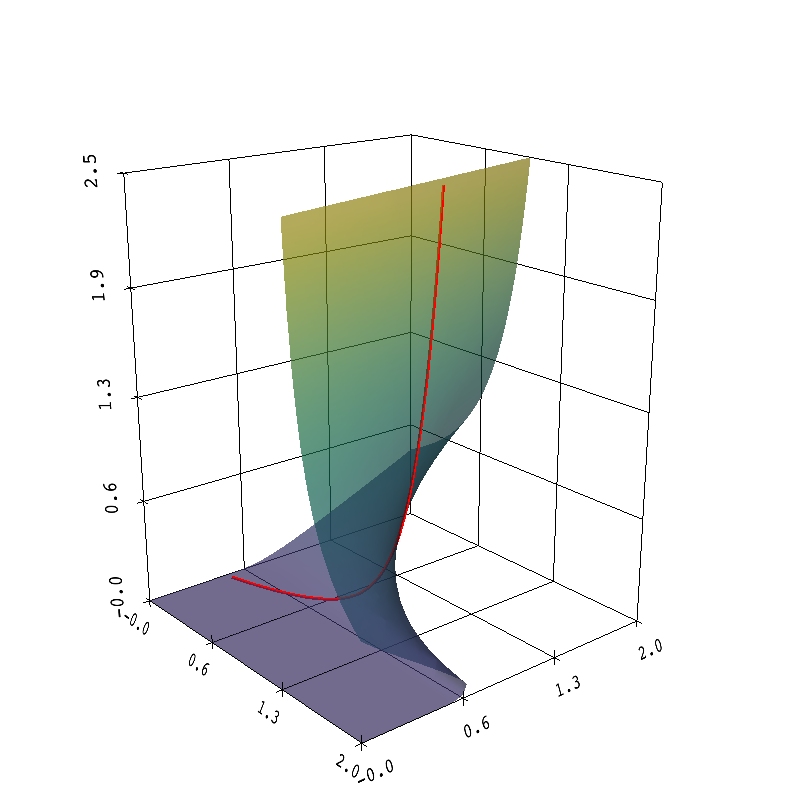

In [9]:
p = pv.Plotter(window_size=[800, 800])
p.add_mesh(surf, interpolate_before_map=True, cmap=lut, show_scalar_bar=False, show_edges=False, opacity=0.7, smooth_shading=True)
p.add_mesh(spline, line_width=3, color='red')
p.show_grid(bold = False, n_xlabels=4, n_ylabels=4, n_zlabels=5, xtitle='', ytitle='', ztitle='')
p.camera_position = [(7,-4,4),(1, 1, 1.3),(0.0, 0, 1)]
p.show()
p.save_graphic("Manifold_MWG.pdf")  

Point Clouds

In [10]:
Man1 = Man_baseline.Result[(Man_baseline.Result[:,4] == 0)]
Man2 = Man_baseline.Result[(Man_baseline.Result[:,4] == 1)]
Man3 = Man_baseline.Result[(Man_baseline.Result[:,4] > 1)]

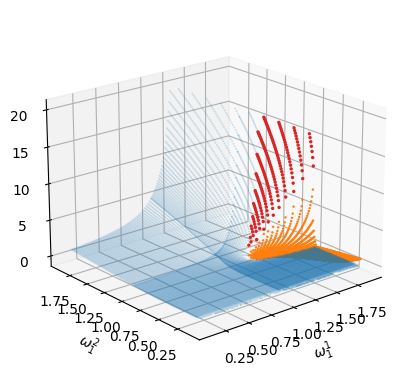

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# ax.scatter(Man[:,0],Man[:,1],Man[:,2], s=5,edgecolor='none',marker='o', alpha = 0.05, cmap='viridis_r')
p = ax.scatter(Man1[:,0],Man1[:,1],np.round(Man1[:,2],3), s=2,edgecolor='none',marker='o', alpha = 0.2, color = 'C0')
p = ax.scatter(Man2[:,0],Man2[:,1],np.round(Man2[:,2],3), s=3,edgecolor='none',marker='o', alpha = 1,  color = 'C1')
p = ax.scatter(Man3[:,0],Man3[:,1],np.round(Man3[:,2],3), s=6,edgecolor='none',marker='o', alpha = 1,  color = 'C3')
ax.set_xlabel(r'$\omega_1^1$')
ax.set_ylabel(r'$\omega_1^2$')
ax.view_init(elev=20., azim=-130)
plt.savefig('PointCloud_MWG.png', dpi=300, bbox_inches='tight')

Varying Parameters

In [12]:
Man_baseline = GetResult(k=9, surf=False)
Man_baseline.ManifoldResult()
Man_baseline.GetContract()
Man_baseline.MF_grid()

Man_r1 = GetResult(k=3, surf=False)
Man_r1.ManifoldResult()
Man_r1.GetContract()
Man_r1.MF_grid()

Man_r2 = GetResult(k=6, surf=False)
Man_r2.ManifoldResult()
Man_r2.GetContract()
Man_r2.MF_grid()

In [13]:
# function to plot the color-filled folded area
def plot_fold_edge(data, color_choice, alpha_choice):

    list1 = np.unique(data[:,0])
    maxlist1 = np.asarray([data[data[:,0] == gg][:,1].max() for gg in list1])
    maxlist2 = np.asarray([data[data[:,0] == gg][:,1].min() for gg in list1])

    # criterion
    list2 = np.unique(data[:,1])
    crit = np.asarray([data[data[:,1] == gg][:,0].min() for gg in list2]).max()
    maxlist2[list1 > crit] = 0

    # edges
    plt.plot(list1, maxlist1, linewidth = 1, color = color_choice)
    plt.plot(list1[list1 <= crit], maxlist2[list1 <= crit], linewidth = 1, color = color_choice)

    # fill colors
    plt.fill_between(list1, maxlist1, maxlist2, color = color_choice, alpha = alpha_choice)

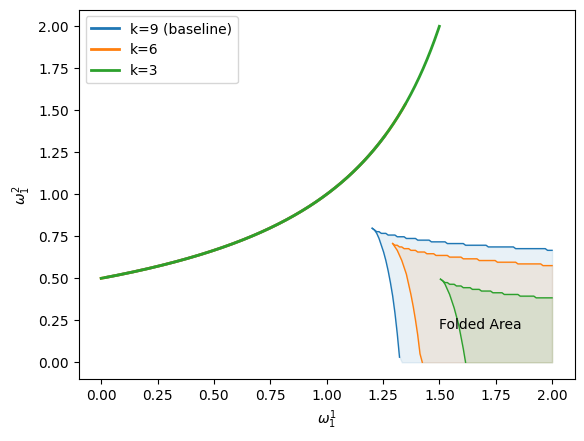

In [14]:
plt.plot(Man_baseline.E_contract[:,2], Man_baseline.E_contract[:,3], linewidth = 2, linestyle = '-', color = 'C0')
plt.plot(Man_r2.E_contract[:,2], Man_r2.E_contract[:,3], linewidth = 2, linestyle = '-', color = 'C1')
plt.plot(Man_r1.E_contract[:,2], Man_r1.E_contract[:,3], linewidth = 2, linestyle = '-', color = 'C2')

plot_fold_edge(Man_baseline.MF_grid, 'C0', 0.1)
plot_fold_edge(Man_r1.MF_grid, 'C2', 0.1)
plot_fold_edge(Man_r2.MF_grid, 'C1', 0.1)

plt.annotate('Folded Area', [1.5,0.2])
plt.xlabel(r'$\omega_1^1$')
plt.ylabel(r'$\omega_1^2$')

plt.legend(['k=9 (baseline)','k=6','k=3'])
plt.savefig('Contract_MWG.png', dpi=300, bbox_inches='tight')